## Import

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from apyori import apriori
from mlxtend.preprocessing import TransactionEncoder

## Groceries Dataset Overview

The dataset contains **38,765 records** of shopping transactions from a grocery store, collected over various dates.

Each record includes the following fields:

- **Member_number**: unique identifier for the customer  
- **Date**: date of the transaction (day-month-year format)  
- **itemDescription**: name of the purchased item  

## Loading the dataset

In [21]:
df = pd.read_csv('Groceries_dataset.csv')
df.head ()

,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk


## Distribution of Basket Sizes

Groups the dataset by unique customer transactions (combining `Member_number` and `Date`), calculates the number of items purchased in each basket, and plots a histogram showing the distribution of basket sizes.

(array([1.008e+04, 2.698e+03, 1.390e+03, 3.440e+02, 1.750e+02, 8.000e+01,
        1.450e+02, 5.000e+01, 0.000e+00, 1.000e+00]),
 array([ 2. ,  2.9,  3.8,  4.7,  5.6,  6.5,  7.4,  8.3,  9.2, 10.1, 11. ]),
 <BarContainer object of 10 artists>)

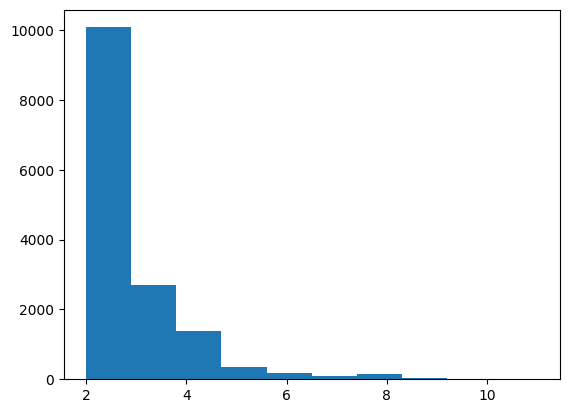

In [22]:
dist = [len(g) for k, g in df.groupby(['Member_number', 'Date'])]
plt.hist(dist)

## Transaction Encoding for Association Analysis

Groups the dataset into baskets of items per customer per date, then uses the `TransactionEncoder` to convert these baskets into a one-hot encoded DataFrame where each column represents an item and each row represents a transaction, ready for frequent pattern mining.

- The `fit()` method learns the unique items across all baskets, and the `transform()` method encodes each transaction as a boolean array indicating the presence (`True`) or absence (`False`) of each item.



In [62]:
te = TransactionEncoder()
baskets = df.groupby(['Member_number', 'Date'])['itemDescription'].apply(list).tolist()
te_ary = te.fit(baskets).transform(baskets)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)
df_encoded

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14958,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,True,False
14959,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
14960,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
14961,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
print("Total baskets:", len(baskets))

Total baskets: 14963


## Mining Frequent Itemsets and Association Rules
Applies the Apriori algorithm on the one-hot encoded transaction DataFrame (`df_encoded`) to find frequent itemsets with a minimum support of 0.3%

Then, generates association rules from these frequent itemsets, filtering rules with a lift metric of at least 0.8, which measures how much more often items occur together than expected by chance.

In [66]:
from mlxtend.frequent_patterns import apriori, association_rules
frequent_itemsets = apriori(df_encoded, min_support=0.003, use_colnames=True)  # 0.003 * 15 000 = 45
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=0.8)
print(len(rules))

136


## Printing Association Rules with Step Skipping

Iterates over rules sorted by lift but prints every second rule (skipping every other one) to avoid showing  mirrored rules


In [68]:
def print_rules(rules_df):
    for idx in range(0, len(rules_df), 2): 
        row = rules_df.iloc[idx]
        antecedents = ', '.join(list(row['antecedents']))
        consequents = ', '.join(list(row['consequents']))
        support = row['support']
        confidence = row['confidence']
        lift = row['lift']

        print(f"Rule: {{{antecedents}}} => {{{consequents}}}")
        print(f"  Support: {support:.3f}")
        print(f"  Confidence: {confidence:.3f}")
        print(f"  Lift: {lift:.3f}")
        print('-' * 50)

        
print_rules(rules.sort_values(by='lift', ascending=False).head(20))

Rule: {bottled beer} => {sausage}
  Support: 0.003
  Confidence: 0.074
  Lift: 1.222
--------------------------------------------------
Rule: {frankfurter} => {other vegetables}
  Support: 0.005
  Confidence: 0.136
  Lift: 1.116
--------------------------------------------------
Rule: {yogurt} => {sausage}
  Support: 0.006
  Confidence: 0.067
  Lift: 1.109
--------------------------------------------------
Rule: {pastry} => {sausage}
  Support: 0.003
  Confidence: 0.062
  Lift: 1.028
--------------------------------------------------
Rule: {soda} => {sausage}
  Support: 0.006
  Confidence: 0.061
  Lift: 1.015
--------------------------------------------------
Rule: {yogurt} => {citrus fruit}
  Support: 0.005
  Confidence: 0.054
  Lift: 1.011
--------------------------------------------------
Rule: {root vegetables} => {shopping bags}
  Support: 0.003
  Confidence: 0.048
  Lift: 1.009
--------------------------------------------------
Rule: {rolls/buns} => {fruit/vegetable juice}
  Supp